# Tidal currents from ADCIRC u,v tidal constituent netcdf file

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import iris
import warnings
import pytz
from datetime import datetime
from pandas import date_range
from matplotlib.dates import date2num
from utide import _ut_constants_fname
from utide.utilities import loadbunch
from utide.harmonics import FUV

In [4]:
ncfile = ('http://geoport.whoi.edu/thredds/dodsC/usgs/vault0/models/tides/'
         'vdatum_gulf_of_maine/adcirc54_38_orig.nc')
wl = -70.7234; el = -70.4532; sl = 41.4258; nl = 41.5643  # Vineyard sound 2.

In [5]:
ncfile = ('http://geoport.whoi.edu/thredds/dodsC/usgs/vault0/models/tides/'
          'FLsab_adcirc54.nc')
print(ncfile)
wl = -85.25; el = -84.75; sl = 29.58; nl = 29.83  # Apalachicola Bay

http://geoport.whoi.edu/thredds/dodsC/usgs/vault0/models/tides/FLsab_adcirc54.nc


In [6]:
ncfile = ('http://geoport.whoi.edu/thredds/dodsC/usgs/vault0/models/tides/'
          'DEdelches01_adcirc54.nc')
print(ncfile)
wl = -74.537378; el = -74.0315462; sl = 39.354624; nl = 39.704567 # South Bay, NY

http://geoport.whoi.edu/thredds/dodsC/usgs/vault0/models/tides/DEdelches01_adcirc54.nc


In [7]:
ncfile = ('http://geoport.whoi.edu/thredds/dodsC/usgs/vault0/models/tides/'
              'NYsndbght02_adcirc54.nc')
print(ncfile)
sl = 40.5457896; wl = -73.664; nl = 40.6990759; el = -73.3376574

http://geoport.whoi.edu/thredds/dodsC/usgs/vault0/models/tides/NYsndbght02_adcirc54.nc


In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cubes = iris.load_raw(ncfile)

print(cubes)

0: Northward Water Velocity Amplitude / (m/s) (Depth-Averaged Output in the Vertical: 1; -- : 218203; -- : 38)
1: Northward Water Velocity Phase / (unknown) (Depth-Averaged Output in the Vertical: 1; -- : 218203; -- : 38)
2: Tide Frequency / (radians/second)   (-- : 38)
3: depth / (meters)                    (-- : 218203)
4: Eastward Water Velocity Amplitude / (m/s) (Depth-Averaged Output in the Vertical: 1; -- : 218203; -- : 38)
5: Horizontal Element Incidence List / (1) (-- : 395562; -- : 3)
6: Tide Constituent / (1)              (-- : 38; -- : 64)
7: latitude / (degrees)                (-- : 218203)
8: Eastward Water Velocity Phase / (unknown) (Depth-Averaged Output in the Vertical: 1; -- : 218203; -- : 38)
9: longitude / (degrees)               (-- : 218203)


In [9]:
units = dict({'knots': 1.9438, 'm/s': 1.0})
consts = ['STEADY', 'M2', 'S2', 'N2', 'K1', 'O1', 'P1', 'M4', 'M6']

In [10]:
start = datetime.strptime('18-Sep-2015 05:00',
                          '%d-%b-%Y %H:%M').replace(tzinfo=pytz.utc)
stop = datetime.strptime('19-Sep-2015 05:00',  # '18-Sep-2015 18:00'
                         '%d-%b-%Y %H:%M').replace(tzinfo=pytz.utc)

dt = 1.0  # Hours.

glocals = date_range(start, stop, freq='1H').to_pydatetime()

ntimes = len(glocals)

In [11]:
def parse_string(name):
    lista = [e.decode().strip() for e in name.tolist()]
    return ''.join(lista)

In [12]:
names = []
data = cubes.extract_strict('Tide Constituent').data

In [13]:
for name in data:
    names.append(parse_string(name))

In [14]:
#from scipy.spatial import Delaunay

depth = cubes.extract_strict('depth').data
latf = cubes.extract_strict('latitude').data
lonf = cubes.extract_strict('longitude').data
frequency = cubes.extract_strict('Tide Frequency').data

# Not sure why this is not working.
# trif = cubes.extract_strict('Horizontal Element Incidence List').data
#trif = Delaunay(zip(lonf, latf)).vertices

In [15]:
# Find indices in box.
import numpy as np
inbox = np.logical_and(np.logical_and(lonf >= wl,
                                      lonf <= el),
                       np.logical_and(latf >= sl,
                                      latf <= nl))
lon = lonf[inbox]
lat = latf[inbox]

In [16]:
lon.shape

(16595,)

In [17]:
con_info = loadbunch(_ut_constants_fname)['const']

In [18]:
# Find the indices of the tidal constituents.

k = 0
ind_nc, ind_ttide = [], []

const_name = [e.strip() for e in con_info['name'].tolist()]

for name in consts:
    try:
        if name == 'STEADY':
            indx = const_name.index('Z0')
        else:
            indx = const_name.index(name)
        k += 1
        ind_ttide.append(indx)
        ind_nc.append(names.index(name))
    except ValueError:
        pass  # `const` not found.

In [19]:
ua = cubes.extract_strict('Eastward Water Velocity Amplitude')
up = cubes.extract_strict('Eastward Water Velocity Phase')
va = cubes.extract_strict('Northward Water Velocity Amplitude')
vp = cubes.extract_strict('Northward Water Velocity Phase')

In [33]:
ua.coord_system

<bound method Cube.coord_system of <iris 'Cube' of Eastward Water Velocity Amplitude / (m/s) (Depth-Averaged Output in the Vertical: 1; -- : 218203; -- : 38)>>

In [21]:
uamp = ua.data[0, inbox, :][:, ind_nc]
vamp = va.data[0, inbox, :][:, ind_nc]
upha = up.data[0, inbox, :][:, ind_nc]
vpha = vp.data[0, inbox, :][:, ind_nc]

In [22]:
ind_nc

[0, 1, 2, 3, 4, 6, 30, 5, 7]

In [23]:
freq_nc = frequency[ind_nc]

In [24]:
print(uamp.shape)
print(freq_nc.shape)

(16595, 9)
(9,)


In [25]:
freq_ttide = con_info['freq'][ind_ttide]

In [26]:
t_tide_names = np.array(const_name)[ind_ttide]

In [27]:
omega_ttide = 2*np.pi * freq_ttide  # Convert from radians/s to radians/hour.

omega = freq_nc * 3600

rllat = 55  # Reference latitude for 3rd order satellites (degrees) (55 is fine always)

In [28]:
# Convert to Matlab datenum.
# (Soon UTide will take python datetime objects.)
jd_start = date2num(start) + 366.1667

In [29]:
# NB: I am not a 100% sure if this is identical to what we had with t_tide.
# ngflgs -> [NodsatLint NodsatNone GwchLint GwchNone]
v, u, f = FUV(t=np.array([jd_start]), tref=np.array([0]),
              lind=np.array([ind_ttide]),
              lat=55, ngflgs=[0, 0, 0, 0])

In [30]:
# Convert phase in radians.
v, u, f = map(np.squeeze, (v, u, f))
v = v * 2 * np.pi
u = u * 2 * np.pi

thours = np.array([d.total_seconds() for d in
                   (glocals - glocals[0])]) / 60 / 60.

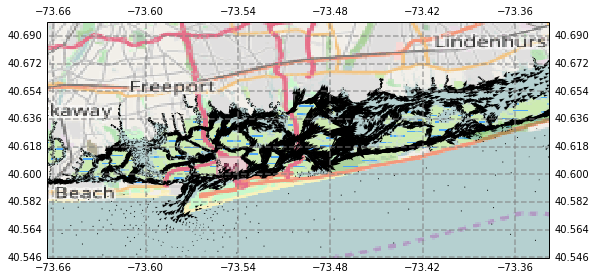

In [62]:
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
tiler = cimgt.OSM()
fig, ax = plt.subplots(figsize=(9, 9),
    subplot_kw=dict(projection=ccrs.PlateCarree()))
#ax.coastlines(resolution='10m')
ax.set_extent([wl, el, sl, nl])
ax.add_image(tiler, 10)

k=0
U = (f * uamp * np.cos(v + thours[k] * omega + u - upha * np.pi/180)).sum(axis=1)
V = (f * vamp * np.cos(v + thours[k] * omega + u - vpha * np.pi/180)).sum(axis=1)

w = units['knots'] * (U + 1j * V)

wf = np.NaN * np.ones_like(lonf, dtype=w.dtype)
wf[inbox] = w

# FIXME: Cannot use masked arrays and tricontour!
# wf = ma.masked_invalid(wf)
# cs = ax.tricontour(lonf, latf, trif, np.abs(wf).filled(fill_value=0))
# fig.colorbar(cs)
#ut, vt = tiler.crs.transform_vectors(ccrs.PlateCarree(), lon,lat,U,V)

subsample = 3
ind = list(range(len(lon)))
np.random.shuffle(ind)
Nvec = int(len(ind) / subsample)
idv = ind[:Nvec]

q = plt.quiver(lon[idv], lat[idv], U[idv], V[idv], scale=10, transform=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
#plt.axis([wl, el, sl, nl])  # Vineyard sound 2.
#q.set_title('{}'.format(glocals[k]))